In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import math
import torch
import torch.nn as nn
import random

In [2]:
import torch
torch.__version__

'1.8.0a0+56b43f4'

In [3]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6"

In [4]:
seed = 69
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark=False

In [43]:
data_path = "train/new_joints_vecs/"
label_path = "train/original_texts/"

action_to_desc = {
        "bend and pull fast" : 0,
        "countermovement jump" : 1,
        "left countermovement jump" : 2,
        "left lunge and twist" : 3,
        "left lunge and twist fast" : 4,
        "right countermovement jump" : 5,
        "right lunge and twist" : 6,
        "right lunge and twist fast" : 7,
        "right single leg squat" : 8,
        "squat" : 9,
        "bend and pull" : 10,
        "left single leg squat" : 11,
        "push up" : 12
    }
desc_to_action = sorted(action_to_desc.keys(), key=lambda x: action_to_desc[x]) 

In [16]:
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from collections import Counter
import torch.optim as optim

class CustomDataset(Dataset):
    def __init__(self, action_to_desc, max_seq_len, stride, mode):
        data_path = mode + "/new_joints_vecs/"
        self.data_path_mot = mode + "/mot_data/"
        label_path = mode + "/original_texts/"
        self.mcs_path = mode + "/mcs/"
        self.data_path = data_path
        self.label_path = label_path
        self.action_to_desc = action_to_desc
        self.max_seq_len = max_seq_len
        self.stride = stride
        self.samples = []
        
        class_counter = Counter()
        
        files = os.listdir(data_path)

        for file in files:
            if not file.endswith('.npy'):
                continue
            # data_file = np.load(data_path + file)
            txt_file = file.replace('.npy','.txt')
            label_file = label_path + txt_file
            mcs_file = self.mcs_path + txt_file
            if not os.path.isfile(mcs_file):
                mcs_score = -1
                continue 
            else:
                with open(mcs_file, 'r') as f:
                    mcs_score = f.readlines()
                    mcs_score = float(mcs_score[0])
            with open(label_file, 'r') as f:
                label_text = f.readlines()
            label = action_to_desc[label_text[0]]
            class_counter[label] += 1
            self.samples.append((data_path + file, label, mcs_score))

        # for i in range(1232 + 1):
        #     file = data_path + str(i) + ".npy"
        #     data_file = np.load(file)
        #     label_file = label_path + str(i) + ".txt"
        #     with open(label_file, 'r') as f:
        #         label_text = f.readlines()
        #     label = action_to_desc[label_text[0]]
        #     class_counter[label] += 1
        #     self.samples.append((file, label))

        # Calculate the maximum frequency of any class
        print("Len num samples in file:", len(self.samples))
        max_class_frequency = max(class_counter.values())

        # Calculate the sampling weight for each class
        self.class_weights = {cls: max_class_frequency / freq for cls, freq in class_counter.items()}
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        while True:
            file, label, mcs_score = self.samples[idx]
            data_file = np.load(file)
            mot_file = self.data_path_mot + file.split('/')[-1]
            mot_file = np.load(mot_file)
            
            data_file = np.concatenate((data_file,mot_file[:-1]), axis = 1)
            # print(data_file.shape)
            
            # Determine sampling probability based on class frequency
            sampling_prob = 1 / self.class_weights[label]

            # Perform sampling based on the calculated probability
            if np.random.uniform() < sampling_prob:
                if data_file.shape[0] <= self.max_seq_len*self.stride:
                    padded_data = np.zeros((self.max_seq_len, data_file.shape[1]))
                    temp = data_file[::self.stride,:]
                    padded_data[:temp.shape[0], :] = temp
                    data_file = padded_data
                    start = 0
                else:
                    # print(len(data_file), max_seq_len)
                    i = np.random.randint(0,len(data_file)-self.max_seq_len*self.stride)
                    data_file = data_file[i:i+self.max_seq_len*self.stride:self.stride, :]
                    start = i
                # print(data_file.shape)
                
                # Only take every alternate time stamp
                alternate_data = data_file # Take every alternate row

                return alternate_data, label, mcs_score, start

# Assuming you have defined data_path, label_path, action_to_desc, and max_seq_len

# Create the custom dataset
# custom_dataset = CustomDataset(data_path, label_path, action_to_desc, max_seq_len)

# Remove None samples
# custom_dataset.samples = [sample for sample in custom_dataset.samples if sample[0] is not None]

# Create the data loader

# dataset_size = len(custom_dataset)
# train_size = int(0.8 * dataset_size)
# test_size = dataset_size - train_size
# train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size])

In [17]:
max_seq_len = 50
batch_size = 512
stride = 3

train_dataset = CustomDataset(action_to_desc, max_seq_len, stride, mode="train")
train_dataset.samples = [sample for sample in train_dataset.samples if sample[0] is not None]
test_dataset = CustomDataset(action_to_desc, max_seq_len, stride, mode="eval")
test_dataset.samples = [sample for sample in test_dataset.samples if sample[0] is not None]

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Len num samples in file: 407
Len num samples in file: 175


In [18]:
input_size = max_seq_len * 299 #36 #263
hidden_size1 = 256
hidden_size2 = 256
num_classes = 13 #len(np.unique(Y))  # Assuming Y contains integer labels
learning_rate = 0.0005
num_epochs = 100

In [19]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes, mcs_classes=5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        # self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3_lab = nn.Linear(hidden_size1, num_classes)
        self.fc3_mcs = nn.Linear(hidden_size1,mcs_classes)
        # self.dp = nn.Dropout(0)
        self.relu = nn.ReLU()

    def forward(self, x, return_embeddings = False):
        # print(x.shape)
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x)) 
        if return_embeddings:
            return x
        # x = self.relu(self.fc2(x)) + x
        x_lab = self.fc3_lab(x)
        x_mcs = self.fc3_mcs(x)
        return x_lab, x_mcs

# Create an instance of the MLP model
model = MLP(input_size, hidden_size1, hidden_size2, num_classes).to('cuda')

criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
def extract_embeddings(dataloader, model):
    embeddings = []
    labels = []
    mcs_scores = []
    start = []
    with torch.no_grad():
        for inputs, lab, mcs, start_point in dataloader:
            cpu_mcs = mcs.cpu().numpy()
            idx = cpu_mcs != -1
            inputs = inputs.float().to('cuda')
            emb = model(inputs, return_embeddings=True)
            embeddings.append(emb.cpu().numpy()[idx])
            labels.append(lab.cpu().numpy()[idx])
            mcs_scores.append(mcs.cpu().numpy()[idx])
            start.append(start_point.cpu().numpy()[idx])
    embeddings = np.vstack(embeddings)
    labels = np.hstack(labels)
    mcs_scores = np.hstack(mcs_scores)
    start = np.hstack(start)
    return embeddings, labels, mcs_scores, start

In [22]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct, total

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for inputs, labels, mcs_scores,_ in train_loader:
        inputs = inputs.float()  # Convert inputs to float
        optimizer.zero_grad()
        outputs_lab, outputs_mcs = model(inputs.to('cuda'))
        
        loss_lab = criterion(outputs_lab, labels.type(torch.long).to('cuda'))
        
        mcs_mask = (mcs_scores != -1)
        if mcs_mask.any():
            loss_mcs = criterion(outputs_mcs[mcs_mask], mcs_scores[mcs_mask].type(torch.long).to('cuda'))
            # loss = loss_lab.mean() + loss_mcs.mean()
            loss = loss_mcs.mean()
        else:
            # loss = loss_lab.mean()
            continue 
            
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch+1)%10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")
        model.eval()
        correct_lab = 0
        total_lab = 0
        correct_mcs = 0
        total_mcs = 0
        with torch.no_grad():
            for inputs, labels, mcs_scores,_ in test_loader:
                inputs = inputs.float()  # Convert inputs to float
                labels = labels.to('cuda')
                mcs_scores = mcs_scores.to('cuda')
                outputs_lab, outputs_mcs = model(inputs.to('cuda'))
                # Calculate label accuracy
                correct, total = calculate_accuracy(outputs_lab, labels)
                correct_lab += correct
                total_lab += total
                
                # Calculate MCS accuracy, ignoring samples with MCS score -1
                mcs_mask = (mcs_scores != -1)
                if mcs_mask.any():
                    correct, total = calculate_accuracy(outputs_mcs[mcs_mask], mcs_scores[mcs_mask])
                    correct_mcs += correct
                    total_mcs += total
            # Print accuracy
            print(f"Label Accuracy on test set: {(correct_lab / total_lab) * 100}%")
            if total_mcs > 0:
                print(f"MCS Accuracy on test set: {(correct_mcs / total_mcs) * 100}%")
            else:
                print("No valid MCS scores in the test set")


Epoch 10/100, Loss: 0.32333409786224365
Label Accuracy on test set: 1.7142857142857144%
MCS Accuracy on test set: 42.857142857142854%
Epoch 20/100, Loss: 0.29765334725379944
Label Accuracy on test set: 1.1428571428571428%
MCS Accuracy on test set: 40.0%
Epoch 30/100, Loss: 0.2660108208656311
Label Accuracy on test set: 2.857142857142857%
MCS Accuracy on test set: 41.14285714285714%
Epoch 40/100, Loss: 0.2329172044992447
Label Accuracy on test set: 2.2857142857142856%
MCS Accuracy on test set: 42.857142857142854%
Epoch 50/100, Loss: 0.23219287395477295
Label Accuracy on test set: 1.7142857142857144%
MCS Accuracy on test set: 45.714285714285715%
Epoch 60/100, Loss: 0.21032091975212097
Label Accuracy on test set: 1.1428571428571428%
MCS Accuracy on test set: 37.714285714285715%
Epoch 70/100, Loss: 0.1910124570131302
Label Accuracy on test set: 1.7142857142857144%
MCS Accuracy on test set: 38.857142857142854%
Epoch 80/100, Loss: 0.1632494330406189
Label Accuracy on test set: 2.285714285714

In [23]:
# Extract and store training embeddings
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
train_embeddings, train_labels, train_mcs_scores, train_start_points = extract_embeddings(train_loader, model)

# Extract and store test embeddings
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_embeddings, test_labels, test_mcs_scores, test_start_points = extract_embeddings(test_loader, model)

In [27]:
from scipy.spatial import distance
# Find closest training points for test embeddings
def find_closest_training_point(test_emb, test_labels, test_mcs_scores, train_embeddings, train_labels, train_mcs_scores, test_start_points, train_start_points):
    closest_points = []
    for i, emb in enumerate(test_emb):
        dists = distance.cdist([emb], train_embeddings, 'euclidean')[0]
        min_idx = np.argmin(dists)
        closest_points.append((train_labels[min_idx], train_mcs_scores[min_idx]))
        # print(f"Test {i}: Closest Train sample:{min_idx} Actual vs Training Label = {test_labels[i]} vs {train_labels[min_idx]}, , "
        #       f"Actual vs Closest MCS Score = {test_mcs_scores[i]} vs {train_mcs_scores[min_idx]}, "
        #       # f"Actual Start point = {test_start_points[i]}, Training start point = {train_start_points[min_idx]}"
        # )
        print(f"Test {i}: Closest Train sample:{min_idx}\nActual vs Training Label = {desc_to_action[test_labels[i]]} vs {desc_to_action[train_labels[min_idx]]}."
              f"Actual vs Closest MCS Score = {test_mcs_scores[i]} vs {train_mcs_scores[min_idx]}, "
              # f"Actual Start point = {test_start_points[i]}, Training start point = {train_start_points[min_idx]}"
        )
    return closest_points

closest_training_points = find_closest_training_point(test_embeddings, test_labels, test_mcs_scores, train_embeddings, train_labels, train_mcs_scores,test_start_points, train_start_points)

Test 0: Closest Train sample:110
Actual vs Training Label = bend and pull vs bend and pull.Actual vs Closest MCS Score = 3.0 vs 2.0, 
Test 1: Closest Train sample:404
Actual vs Training Label = bend and pull full vs bend and pull full.Actual vs Closest MCS Score = 3.0 vs 1.0, 
Test 2: Closest Train sample:242
Actual vs Training Label = bend and pull full vs bend and pull.Actual vs Closest MCS Score = 3.0 vs 3.0, 
Test 3: Closest Train sample:74
Actual vs Training Label = bend and pull full vs bend and pull full.Actual vs Closest MCS Score = 3.0 vs 1.0, 
Test 4: Closest Train sample:379
Actual vs Training Label = countermovement jump vs countermovement jump.Actual vs Closest MCS Score = 3.0 vs 2.0, 
Test 5: Closest Train sample:191
Actual vs Training Label = countermovement jump vs left countermovement jump.Actual vs Closest MCS Score = 3.0 vs 3.0, 
Test 6: Closest Train sample:379
Actual vs Training Label = countermovement jump vs countermovement jump.Actual vs Closest MCS Score = 3.0 

# Data Distribution

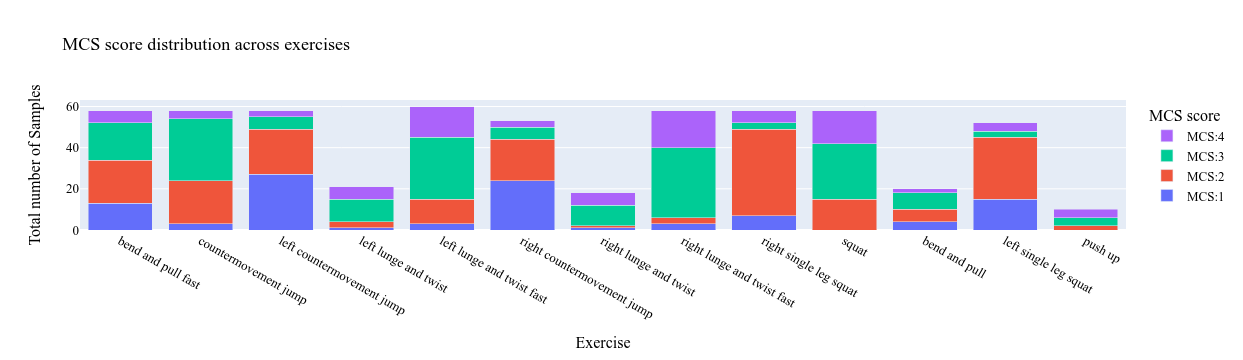

In [49]:
import plotly.graph_objects as go


fig = go.Figure(data=[go.Bar(name=f'MCS:{i}', x=desc_to_action, y=[ (test_mcs_scores[test_labels==j] == i).sum() + (train_mcs_scores[train_labels==j] == i).sum()  for j,_ in enumerate(desc_to_action) ] ) for i in range(1,5)])
# Change the bar mode
fig.update_layout(barmode='stack')

fig.update_layout(
    title="MCS score distribution across exercises",
    xaxis_title="Exercise",
    yaxis_title="Total number of Samples",
    legend_title="MCS score",
    font=dict(
        family="Times New Roman",
        size=13,
        color="Black"
    )
)

fig.show()

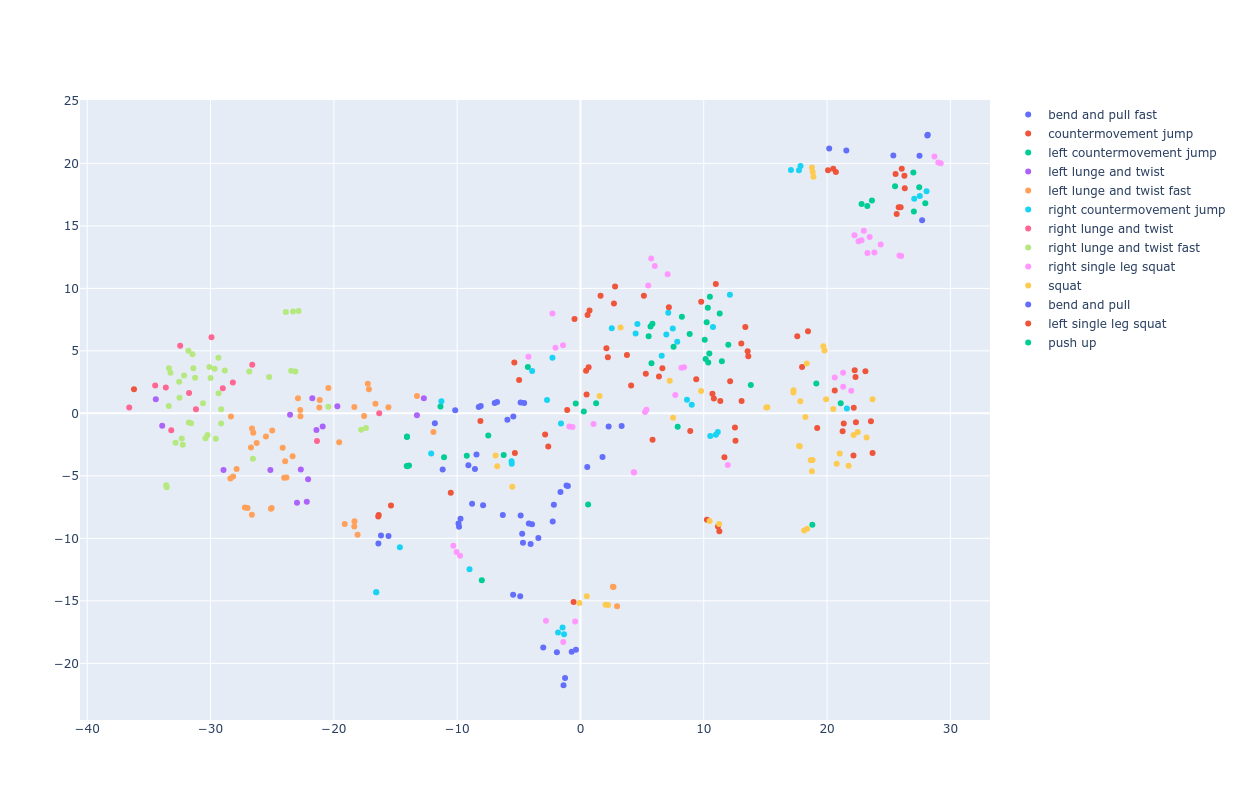

In [63]:
from sklearn.manifold import TSNE 

tsne = TSNE(n_components=2,random_state=0)
train_projections = tsne.fit_transform(train_embeddings)

fig = go.Figure(data=[go.Scatter(name=exer,x=train_projections[ train_labels==i,0],y=train_projections[train_labels==i,1],mode='markers')
                     for i,exer in enumerate(desc_to_action)  ])
fig.update_layout(width=1600, height=800)
fig.show()